### Import Fashion MNIST dataset

In [30]:
!pip install wget

In [31]:
import wget
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [32]:
data_path = './data-partie-1'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
if not os.listdir(data_path) :
    wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz', data_path)
    wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz', data_path)
    wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz', data_path)
    wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz', data_path)

In [33]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py 

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [34]:
X, y = load_mnist(data_path, kind='train')
X_test, y_test = load_mnist(data_path, kind='t10k')

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

(28, 28)


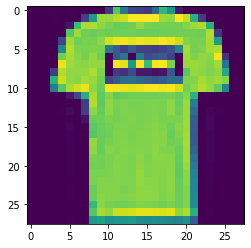

In [36]:
print(X_train[1].reshape(28,28).shape)
plt.imshow(X_train[1].reshape(28,28))

In [37]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(51000, 784)
(10000, 784)
(9000, 784)


### Preprocess data

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
def pre_process_data(X_train, y_train, X_test, y_test, X_val, y_val):
    # Normalize
    X_train = ((X_train / 255.) - 0.1307) / 0.3081
    X_test = ((X_test / 255.) - 0.1307) / 0.3081
    X_val = ((X_val / 255.) - 0.1307) / 0.3081

    enc = OneHotEncoder(sparse=False, categories='auto')
    
    y_train = enc.fit_transform(y_train.reshape(len(y_train), -1))
    y_test = enc.transform(y_test.reshape(len(y_test), -1))
    y_val = enc.transform(y_val.reshape(len(y_val), -1))

    return X_train, y_train, X_test, y_test, X_val, y_val

In [40]:
X_train, y_train, X_test, y_test, X_val, y_val = pre_process_data(X_train, y_train, X_test, y_test, X_val, y_val)

### Neural Network

In [41]:
import matplotlib.pyplot as plt
import numpy as np

In [42]:
class NeuralNetwork:
    def __init__(self, layers_size, batch_size=64):
        self.layers_size = layers_size
        self.number_layers = len(self.layers_size)
        self.batch_size = batch_size
        self.costs = []
        self.costs_val = []
        self.val_accuracies = []
    
    
    def relu(self, Z):
        y = np.copy(Z)
        y[y < 0] = 0
        return y
    
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    
    def cost_function(self, Y, Y_hat):
        return np.mean(- np.sum(Y * np.log(Y_hat.T + 1e-8), axis=1))
    
    
    def feed_forward(self, X, params):
        values = {}
        
        len_layers = len(self.layers_size)
        
        # hidden layers
        values['A0'] = X.T 
        for i in range(self.number_layers - 1):
            values["Z" + str(i + 1)] = np.matmul(params["W" + str(i + 1)], values["A" + str(i)]) + params["b" + str(i + 1)]
            values["A" + str(i + 1)] = self.relu(values["Z" + str(i + 1)])
            
        # output layer  
        values["Z" + str(self.number_layers)] = np.matmul(params["W" + str(self.number_layers)], values["A" + str(i + 1)]) + params["b" + str(self.number_layers)]
        values["A" + str(self.number_layers)] = self.softmax(values["Z" + str(self.number_layers)])

        return values
    
    
    def relu_derivative(self, Z):
        y = np.copy(Z)
        y[y >= 0] = 1
        y[y < 0] = 0
        return y 
    
    
    def back_propagation(self, X, Y, params, values_ff):
        gradients = {}
        dW = {}
        db = {}
        
        # reverse output layer (softmax-loss)
        dZ = values_ff["A" + str(self.number_layers)] - Y.T

        gradients["dW" + str(self.number_layers)] = np.matmul(dZ, values_ff["A" + str(self.number_layers - 1)].T) / self.batch_size
        gradients["db" + str(self.number_layers)] = np.sum(dZ, axis=1, keepdims=True) / self.batch_size
        
        dAPrev = np.matmul(params["W" + str(self.number_layers)].T, dZ)
        
        for i in range(self.number_layers - 1, 0, -1):
            dZ = dAPrev * self.relu_derivative(values_ff["Z" + str(i)])
            gradients["dW" + str(i)] = np.matmul(dZ, values_ff["A" + str(i - 1)].T) / self.batch_size
            gradients["db" + str(i)] = np.sum(dZ, axis=1, keepdims=True) / self.batch_size
            
            if i > 1:
                dAPrev = np.matmul(params["W" + str(i)].T, dZ)

        return gradients
    
    
    def initialize_weights(self):
        np.random.seed(42)
        
        weights = {}
        for i in range(1, len(self.layers_size)):
            bound = 1. /np.sqrt(self.layers_size[i - 1]) # Pour que les weights et biais soient initialisees de la même facon qu'en pytorch
            weights["W" + str(i)] = np.random.uniform(-bound, bound, (self.layers_size[i], self.layers_size[i - 1]))
            weights["b" + str(i)] = np.random.uniform(-bound, bound, (self.layers_size[i], 1))
        return weights
    
    
    def fit(self, X_train, Y_train, X_val, Y_val, X_test, Y_test, learning_rate=0.01, n_epochs=25):
        np.random.seed(42)
        
        self.layers_size.insert(0, X.shape[1])        
        weights = self.initialize_weights()

        # train
        for epoch in range(n_epochs):
            i=0
            while (i < X_train.shape[0]):
                x_batch = X_train[i:i + self.batch_size]
                y_batch = Y_train[i:i + self.batch_size]
                i += self.batch_size

                values_ff = self.feed_forward(x_batch, weights)
                gradients = self.back_propagation(x_batch, y_batch, weights, values_ff)

                for j in range(1, self.number_layers + 1):
                    weights["W" + str(j)] = weights["W" + str(j)] - learning_rate * gradients["dW" + str(j)]
                    weights["b" + str(j)] = weights["b" + str(j)] - learning_rate * gradients["db" + str(j)]

            values_ff_train = self.feed_forward(X_train, weights)
            train_cost = self.cost_function(Y_train, values_ff_train["A" + str(self.number_layers)])
            self.costs.append(train_cost)
            values_ff_val = self.feed_forward(X_val, weights)
            val_cost = self.cost_function(Y_val, values_ff_val["A" + str(self.number_layers)])
            self.costs_val.append(val_cost)
            
            training_acc = self.get_accuracy(X_train, Y_train, values_ff_train)
            validation_acc = self.get_accuracy(X_val, Y_val, values_ff_val)
            self.val_accuracies.append(validation_acc)
            print("Epoch {}: training cost = {}, validation cost = {}, training accuracy = {}, validation accuracy = {}"
                  .format(epoch + 1, train_cost, val_cost, training_acc, validation_acc))

        print("Training done!")
        
        values_ff_test = self.feed_forward(X_test, weights)
        test_acc = self.get_accuracy(X_test, Y_test, values_ff_test) 
        print("test accuracy = {}, validation accuracy = {}".format(test_acc, validation_acc))
    
    
    def get_accuracy(self, X, y, values_ff):
        A = values_ff["A" + str(self.number_layers)]
        
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(y, axis=1)
        
        scores = Y == y_hat

        return np.sum(scores) / len(y)        
    
    
    def plot_cost(self):
        plt.figure()
        plt.title("Loss curve of Python implementation")
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.plot(np.arange(len(self.costs_val)), self.costs_val)
        plt.xlabel("Epochs")
        plt.ylabel("Negative log likelihood")
        plt.legend(['training', 'validation'], loc="upper right")
        plt.show()
        
    def plot_accuracy(self):
        plt.figure()
        plt.title("Accuracy of Python implementation")
        plt.plot(np.arange(len(self.val_accuracies)), self.val_accuracies)
        plt.xlabel("Epochs")
        plt.ylabel("Validation Accuracy")
        plt.legend(['validation'], loc="lower right")
        plt.show()

Epoch 1: training cost = 0.5591164038846455, validation cost = 0.567786212504369, training accuracy = 0.8077058823529412, validation accuracy = 0.8056666666666666
Epoch 2: training cost = 0.47211715138845556, validation cost = 0.48770968896401923, training accuracy = 0.8351960784313726, validation accuracy = 0.8278888888888889
Epoch 3: training cost = 0.433520954995847, validation cost = 0.4521539112419813, training accuracy = 0.8482745098039216, validation accuracy = 0.8427777777777777
Epoch 4: training cost = 0.4079945047297149, validation cost = 0.4290848916445183, training accuracy = 0.8566666666666667, validation accuracy = 0.848
Epoch 5: training cost = 0.388247504282537, validation cost = 0.41143537139102376, training accuracy = 0.8628627450980392, validation accuracy = 0.8542222222222222
Epoch 6: training cost = 0.37240580006097346, validation cost = 0.3979533577999647, training accuracy = 0.8678235294117647, validation accuracy = 0.857
Epoch 7: training cost = 0.35852708388009

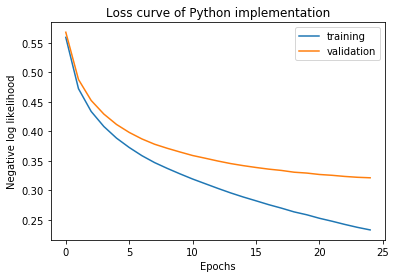

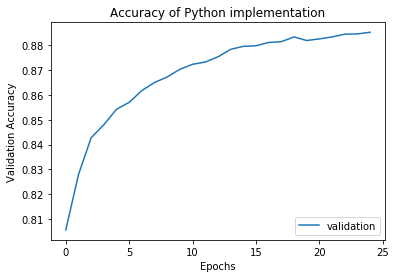

In [43]:
layers_dims = [300, 300, 10]
nn = NeuralNetwork(layers_dims)

nn.fit(X_train, y_train, X_val, y_val, X_test, y_test, 0.01)
nn.plot_cost()
nn.plot_accuracy()
from_scratch_train_loss = nn.costs
from_scratch_val_loss = nn.costs_val
from_scratch_val_accuracies = nn.val_accuracies


In [44]:
%store from_scratch_train_loss
%store from_scratch_val_loss
%store from_scratch_val_accuracies 

Stored 'from_scratch_train_loss' (list)
Stored 'from_scratch_val_loss' (list)
Stored 'from_scratch_val_accuracies' (list)
